# Improving Orbit Propagation of Space Objects

What is there left to do?

- Feature Selection
- Feature Normalisation
- Parameter Optimisation
- Model Checkpoints
- Cross Validation
- Dropout
- L-2 Regularisation


We test multiple models, namely
- Linear Regression,
- Random Forest,
- Ada Boost,
- Decision,
- XGBoost,
- MLP

## Data Loading & Pre-Processing

In [1]:
# Libraries:
import os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Sci-Kit Learn Packages:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing   import MinMaxScaler
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error

# Loading Data:
def load_data (data_id = "31698", coor_type = "XYZ"):
    if data_id not in ["31698", "31722", "36605", "40309"]:
        raise ValueError("Invalid `data_id` value.")
    if coor_type not in ["XYZ", "RTN"]:
        raise ValueError("Invalid `coor_type` value.")
    full_dir = os.path.join("./Dataset", data_id, coor_type, "P1.csv")
    return pd.read_csv(full_dir)

# Visualisation:
df = load_data(coor_type = "RTN")

# Remove `Unnamed: 0` Column:
df.drop("Unnamed: 0", axis = "columns", inplace = True)

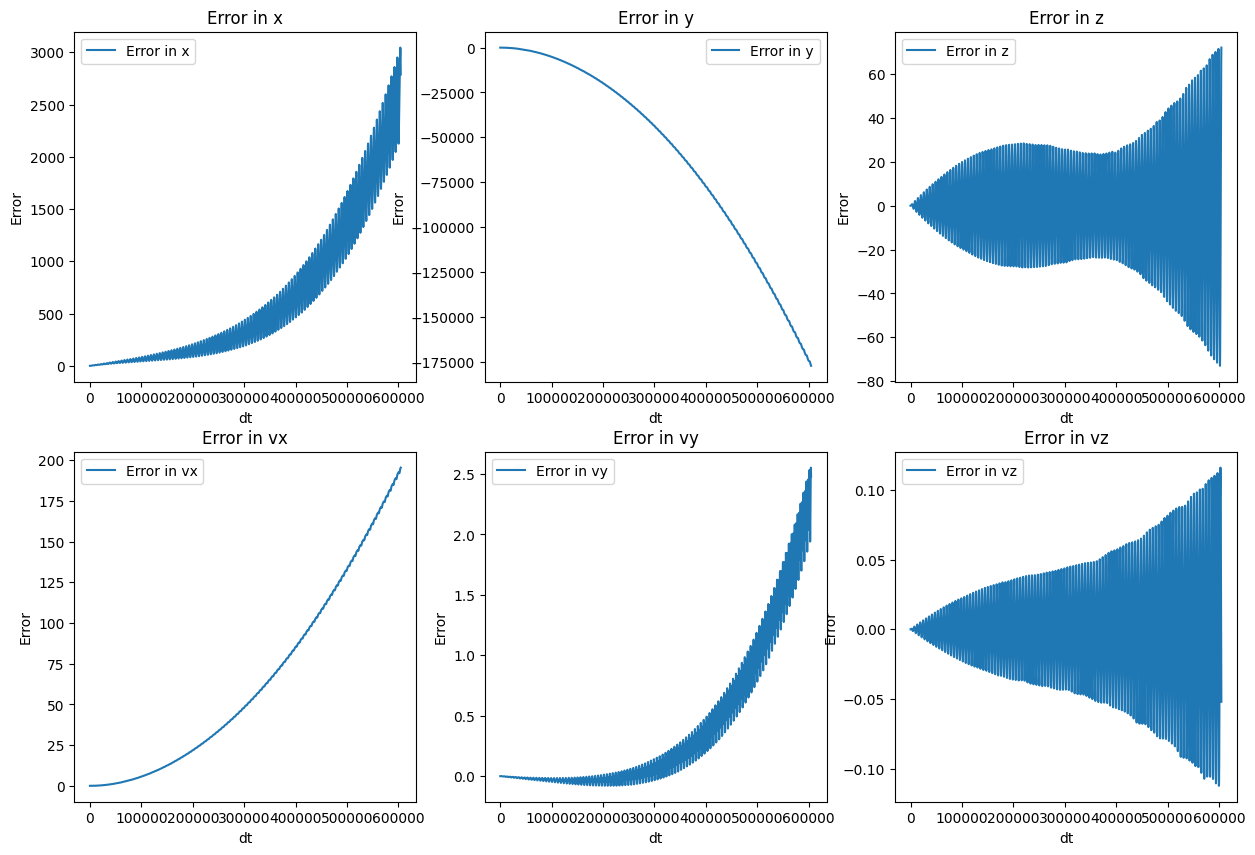

In [2]:
def plot_errors (df = df, target_time = 0.0):
    if target_time not in df["Time"].unique():
        raise ValueError("Invalid `target_time` value.")
    # Filter by `Time` = target_time.
    df_filter = df[df["Time"] == target_time]
    # Create subplots.
    fig, axs = plt.subplots(2, 3, figsize = (15, 10))
    # Plot differences:
    for idx, coord in enumerate(["x", "y", "z", "vx", "vy", "vz"]):
        true_val = "True_" + coord
        pred_val = "Approx_" + coord
        ax = axs[idx // 3, idx % 3]
        ax.plot(
            df_filter["Delta_t"], df_filter[pred_val] - df_filter[true_val],
            label = "Error in " + coord
        )
        ax.set_xlabel("dt")
        ax.set_ylabel("Error")
        ax.set_title("Error in " + coord)
        ax.legend()
    plt.show()

plot_errors()

In [3]:
# Replace `True` and `Approx` Columns by their Error:
for coord in ["x", "y", "z"]:
    # Create Error Columns:
    # 1: For Position
    true_pos = "True_" + coord
    pred_pos = "Approx_" + coord
    error_pos = "Error_" + coord
    df[error_pos] = df[pred_pos] - df[true_pos]
    # 2: For Velocity
    true_vel = "True_v" + coord
    pred_vel = "Approx_v" + coord
    error_vel = "Error_v" + coord
    df[error_vel] = df[pred_pos] - df[true_pos]
    # Drop `True` and `Approx` Columns:
    # 1: For Position
    df.drop(true_pos, axis = "columns", inplace = True)
    df.drop(pred_pos, axis = "columns", inplace = True)
    # 2: For Velocity
    df.drop(true_vel, axis = "columns", inplace = True)
    df.drop(pred_vel, axis = "columns", inplace = True)

## Sample Model for the `X` Coordinate Value

In [6]:
def filter_data_by_label (df, target_label = "x"):
    if target_label not in ["x", "y", "z", "vx", "vy", "vz"]:
        raise ValueError("Invalid `target_label` value.")
    # Select Columns:
    target_columns = [
        "Time",
        "Delta_t", 
        "c1_" + target_label, "c1_t",
        "c2_" + target_label, "c2_t",
        "c3_" + target_label, "c3_t",
        "c4_" + target_label, "c4_t",
        "c5_" + target_label, "c5_t"
    ]
    return df[target_columns], df["Error_" + target_label]

X, y = filter_data_by_label (df, target_label = "x")

def group_train_test_split (X, y, group_factor = "Time"):
    groups = X[group_factor]
    gss = GroupShuffleSplit(
        n_splits = 1, test_size = 0.2, random_state = 42
    )
    for i, (train_index, test_index) in enumerate(gss.split(X, y, groups)):
        X_train = X.iloc[train_index]; X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]; y_test = y.iloc[test_index]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = group_train_test_split (X, y)

## Linear Regression

In [ ]:
# Remove `Time` Column:
df.drop("Time", axis = "columns", inplace = True)

## Linear Regression

Normalised Features:
Linear Regression's RMSE:  505.10


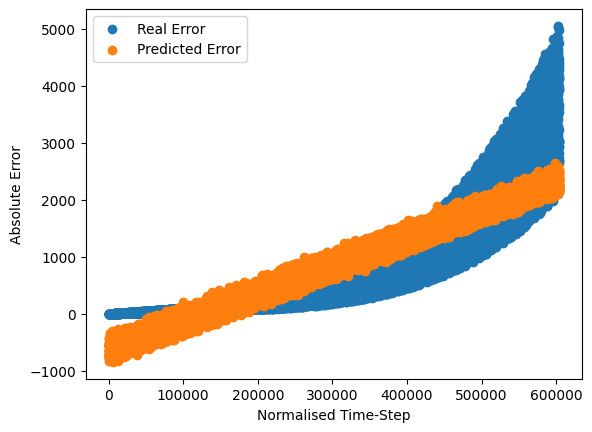

In [5]:
def lin_reg_results (X_train, y_train, X_test, y_test):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    predictions = lin_reg.predict(X_test)
    lin_reg_mse = mean_squared_error(predictions, y_test)
    print(f"Linear Regression's RMSE: {math.sqrt(lin_reg_mse) : .2f}")
    return predictions

def scatter_predictions (X_test, y_test, predictions):
    plt.scatter(X_test["Delta_t"], y_test, label = "Real Error")
    plt.scatter(X_test["Delta_t"], predictions, label = "Predicted Error")
    plt.xlabel("Normalised Time-Step")
    plt.ylabel("Absolute Error")
    plt.legend()
    plt.show()

# Normalisation:
scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Normalised Features:
print("Normalised Features:")
predictions = lin_reg_results(X_train_norm, y_train, X_test_norm, y_test)

scatter_predictions (X_test, y_test, predictions)

Observation: The simple linear regression model is not sufficiently complex to model the error.

## Polynomial Feature Scaling:

Polynomial Feature Scaling Results: (Factor = 2)
Linear Regression's RMSE:  278.79


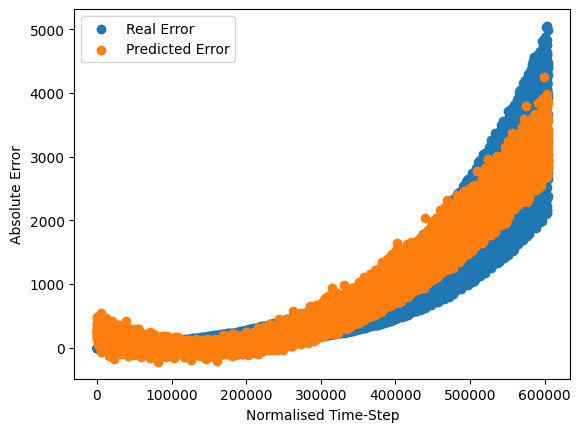

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial Scaling:
factor = 2
poly = PolynomialFeatures(factor)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Normalisation:
scaler = MinMaxScaler()
X_train_poly_norm = scaler.fit_transform(X_train_poly)
X_test_poly_norm = scaler.transform(X_test_poly)

# Normalised Features:
print(f"Polynomial Feature Scaling Results: (Factor = {factor})")
predictions = lin_reg_results(X_train_poly_norm, y_train, X_test_poly_norm, y_test)

scatter_predictions (X_test, y_test, predictions)

## Multi-Layer Perceptron

